In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def gen_sn(M, I, anti_paths=True, mo_match=True):
    ''' Function to generate random numbers for simulation.
    
    Parameters
    ==========
    M : int
        number of time intervals for discretization
    I : int
        number of paths to be simulated
    anti_paths: boolean
        use of antithetic variates
    mo_math : boolean
        use of moment matching
    '''
    if anti_paths is True:
        sn = npr.standard_normal((M + 1, I / 2))
        sn = np.concatenate((sn, -sn), axis=1)
    else:
        sn = npr.standard_normal((M + 1, I))
    if mo_match is True:
        sn = (sn - sn.mean()) / sn.std()
    return sn

In [3]:
S0 = 100.
r = 0.05
sigma = 0.25
T = 0.25
I = 50000
def gbm_mcs_stat(K):
    ''' Valuation of European call option in Black-Scholes-Merton
    by Monte Carlo simulation (of index level at maturity)
    
    Parameters
    ==========
    K : float
        (positive) strike price of the option
    
    Returns
    =======
    C0 : float
        estimated present value of European call option
    '''
    sn = gen_sn(1, I)
    # simulate index level at maturity
    ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T 
                 + sigma * np.sqrt(T) * sn[1])
    # calculate payoff at maturity
    hT = np.maximum(ST - K, 0)
    # calculate MCS estimator
    C0 = np.exp(-r * T) * 1 / I * np.sum(hT)
    return C0

In [4]:

def gbm_mcs_dyna(K, option='call'):
    ''' Valuation of European options in Black-Scholes-Merton
    by Monte Carlo simulation (of index level paths)
    
    Parameters
    ==========
    K : float
        (positive) strike price of the option
    option : string
        type of the option to be valued ('call', 'put')
    
    Returns
    =======
    C0 : float
        estimated present value of European call option
    '''
    M=50
    dt = T / M
    # simulation of index level paths
    S = np.zeros((M + 1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt 
                + sigma * np.sqrt(dt) * sn[t])
    # case-based calculation of payoff
    if option == 'call':
        hT = np.maximum(S[-1] - K, 0)
    else:
        hT = np.maximum(K - S[-1], 0)
    # calculation of MCS estimator
    C0 = np.exp(-r * T) * 1 / I * np.sum(hT)
    return C0

In [5]:
gbm_mcs_dyna(K=110., option='call')

1.993800032127294

In [6]:
from bsm_functions import bsm_call_value
stat_res = []
dyna_res = []
anal_res = []
k_list = np.arange(80., 120.1, 5.)
np.random.seed(200000)
for K in k_list:
    stat_res.append(gbm_mcs_stat(K))
    dyna_res.append(gbm_mcs_dyna(K))
    anal_res.append(bsm_call_value(S0, K, T, r, sigma))
stat_res = np.array(stat_res)
dyna_res = np.array(dyna_res)
anal_res = np.array(anal_res)

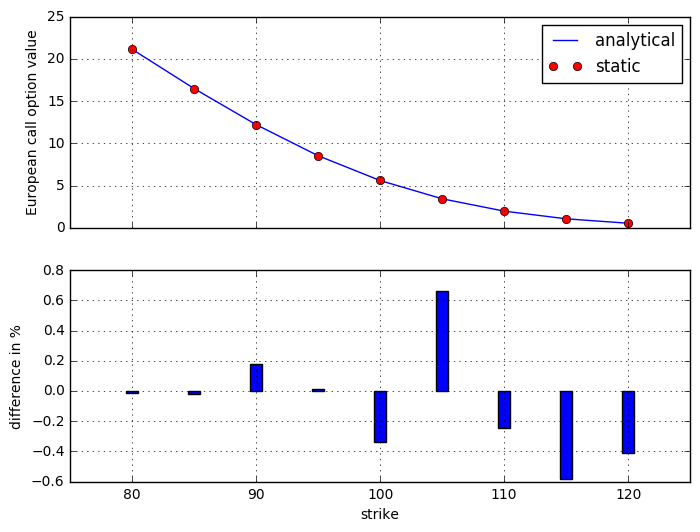

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax1.plot(k_list, anal_res, 'b', label='analytical')
ax1.plot(k_list, stat_res, 'ro', label='static')
ax1.set_ylabel('European call option value')
ax1.grid(True)
ax1.legend(loc=0)
ax1.set_ylim(ymin=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (anal_res - stat_res) / anal_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)
# tag: opt_val_comp_1
# title: Comparsion of static and dynamic Monte Carlo estimator values
# size: 60

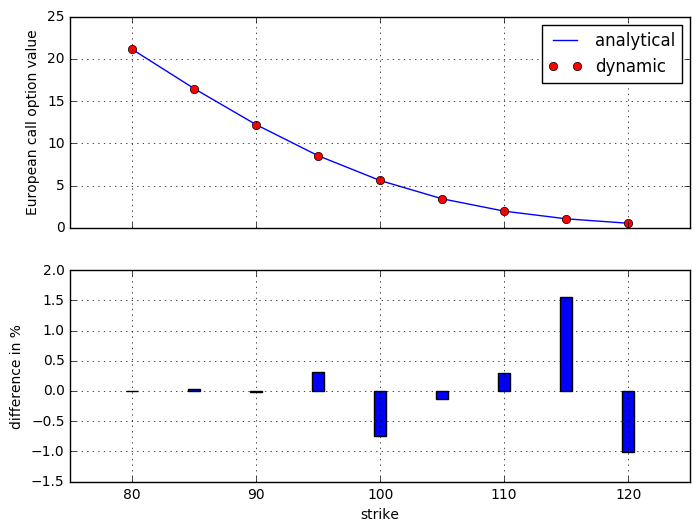

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax1.plot(k_list, anal_res, 'b', label='analytical')
ax1.plot(k_list, dyna_res, 'ro', label='dynamic')
ax1.set_ylabel('European call option value')
ax1.grid(True)
ax1.legend(loc=0)
ax1.set_ylim(ymin=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (anal_res - dyna_res) / anal_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)
# tag: opt_val_comp_2
# title: Comparsion of static and dynamic Monte Carlo estimator values
# size: 60